# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 11            
model_seed = 1           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.3464 | Test Loss 2.3196 | accs Train 0.0333 Test 0.0619


Epoch 100/3000: Train Loss 0.0083 | Test Loss 1.2779 | accs Train 1.0000 Test 0.6764


Epoch 200/3000: Train Loss 0.0033 | Test Loss 1.3517 | accs Train 1.0000 Test 0.6799


Epoch 300/3000: Train Loss 0.0020 | Test Loss 1.3906 | accs Train 1.0000 Test 0.6813


Epoch 400/3000: Train Loss 0.0015 | Test Loss 1.4182 | accs Train 1.0000 Test 0.6823


Epoch 500/3000: Train Loss 0.0011 | Test Loss 1.4393 | accs Train 1.0000 Test 0.6824


Epoch 600/3000: Train Loss 0.0009 | Test Loss 1.4562 | accs Train 1.0000 Test 0.6828


Epoch 700/3000: Train Loss 0.0008 | Test Loss 1.4702 | accs Train 1.0000 Test 0.6836


Epoch 800/3000: Train Loss 0.0007 | Test Loss 1.4823 | accs Train 1.0000 Test 0.6843


Epoch 900/3000: Train Loss 0.0006 | Test Loss 1.4927 | accs Train 1.0000 Test 0.6846


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.5018 | accs Train 1.0000 Test 0.6850


Epoch 1100/3000: Train Loss 0.0005 | Test Loss 1.5098 | accs Train 1.0000 Test 0.6849


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.5170 | accs Train 1.0000 Test 0.6848


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.5235 | accs Train 1.0000 Test 0.6850


Epoch 1400/3000: Train Loss 0.0004 | Test Loss 1.5293 | accs Train 1.0000 Test 0.6849


Epoch 1500/3000: Train Loss 0.0004 | Test Loss 1.5346 | accs Train 1.0000 Test 0.6853


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.5395 | accs Train 1.0000 Test 0.6852


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.5440 | accs Train 1.0000 Test 0.6856


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.5481 | accs Train 1.0000 Test 0.6860


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.5518 | accs Train 1.0000 Test 0.6863


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.5552 | accs Train 1.0000 Test 0.6864


Epoch 2100/3000: Train Loss 0.0003 | Test Loss 1.5584 | accs Train 1.0000 Test 0.6864


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.5614 | accs Train 1.0000 Test 0.6867


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.5641 | accs Train 1.0000 Test 0.6868


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.5667 | accs Train 1.0000 Test 0.6871


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.5690 | accs Train 1.0000 Test 0.6872


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.5712 | accs Train 1.0000 Test 0.6876


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.5732 | accs Train 1.0000 Test 0.6877


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.5751 | accs Train 1.0000 Test 0.6881


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.5769 | accs Train 1.0000 Test 0.6881


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.5785 | accs Train 1.0000 Test 0.6881
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3214 | Test Loss 2.3199 | accs Train 0.0500 Test 0.0626


Epoch 100/3000: Train Loss 0.1434 | Test Loss 0.4587 | accs Train 0.9717 Test 0.8653


Epoch 200/3000: Train Loss 0.0271 | Test Loss 0.5028 | accs Train 1.0000 Test 0.8706


Epoch 300/3000: Train Loss 0.0117 | Test Loss 0.5407 | accs Train 1.0000 Test 0.8706


Epoch 400/3000: Train Loss 0.0071 | Test Loss 0.5667 | accs Train 1.0000 Test 0.8711


Epoch 500/3000: Train Loss 0.0049 | Test Loss 0.5861 | accs Train 1.0000 Test 0.8706


Epoch 600/3000: Train Loss 0.0037 | Test Loss 0.6014 | accs Train 1.0000 Test 0.8708


Epoch 700/3000: Train Loss 0.0030 | Test Loss 0.6140 | accs Train 1.0000 Test 0.8713


Epoch 800/3000: Train Loss 0.0025 | Test Loss 0.6247 | accs Train 1.0000 Test 0.8709


Epoch 900/3000: Train Loss 0.0021 | Test Loss 0.6339 | accs Train 1.0000 Test 0.8713


Epoch 1000/3000: Train Loss 0.0018 | Test Loss 0.6419 | accs Train 1.0000 Test 0.8713


Epoch 1100/3000: Train Loss 0.0016 | Test Loss 0.6491 | accs Train 1.0000 Test 0.8715


Epoch 1200/3000: Train Loss 0.0015 | Test Loss 0.6555 | accs Train 1.0000 Test 0.8715


Epoch 1300/3000: Train Loss 0.0013 | Test Loss 0.6612 | accs Train 1.0000 Test 0.8718


Epoch 1400/3000: Train Loss 0.0012 | Test Loss 0.6664 | accs Train 1.0000 Test 0.8717


Epoch 1500/3000: Train Loss 0.0011 | Test Loss 0.6712 | accs Train 1.0000 Test 0.8717


Epoch 1600/3000: Train Loss 0.0010 | Test Loss 0.6755 | accs Train 1.0000 Test 0.8717


Epoch 1700/3000: Train Loss 0.0010 | Test Loss 0.6795 | accs Train 1.0000 Test 0.8716


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6832 | accs Train 1.0000 Test 0.8718


Epoch 1900/3000: Train Loss 0.0008 | Test Loss 0.6867 | accs Train 1.0000 Test 0.8719


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6899 | accs Train 1.0000 Test 0.8719


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6928 | accs Train 1.0000 Test 0.8719


Epoch 2200/3000: Train Loss 0.0007 | Test Loss 0.6956 | accs Train 1.0000 Test 0.8718


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.6982 | accs Train 1.0000 Test 0.8720


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.7007 | accs Train 1.0000 Test 0.8721


Epoch 2500/3000: Train Loss 0.0006 | Test Loss 0.7030 | accs Train 1.0000 Test 0.8723


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.7051 | accs Train 1.0000 Test 0.8723


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.7072 | accs Train 1.0000 Test 0.8722


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.7091 | accs Train 1.0000 Test 0.8724


Epoch 2900/3000: Train Loss 0.0005 | Test Loss 0.7109 | accs Train 1.0000 Test 0.8722


Epoch 3000/3000: Train Loss 0.0005 | Test Loss 0.7126 | accs Train 1.0000 Test 0.8720
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3176 | Test Loss 2.3201 | accs Train 0.0570 Test 0.0626


Epoch 100/3000: Train Loss 0.2637 | Test Loss 0.3728 | accs Train 0.9300 Test 0.8922


Epoch 200/3000: Train Loss 0.1241 | Test Loss 0.3336 | accs Train 0.9700 Test 0.9050


Epoch 300/3000: Train Loss 0.0619 | Test Loss 0.3450 | accs Train 0.9930 Test 0.9061


Epoch 400/3000: Train Loss 0.0337 | Test Loss 0.3649 | accs Train 0.9990 Test 0.9069


Epoch 500/3000: Train Loss 0.0201 | Test Loss 0.3834 | accs Train 0.9995 Test 0.9074


Epoch 600/3000: Train Loss 0.0134 | Test Loss 0.3992 | accs Train 1.0000 Test 0.9078


Epoch 700/3000: Train Loss 0.0098 | Test Loss 0.4124 | accs Train 1.0000 Test 0.9081


Epoch 800/3000: Train Loss 0.0076 | Test Loss 0.4234 | accs Train 1.0000 Test 0.9083


Epoch 900/3000: Train Loss 0.0061 | Test Loss 0.4327 | accs Train 1.0000 Test 0.9088


Epoch 1000/3000: Train Loss 0.0051 | Test Loss 0.4408 | accs Train 1.0000 Test 0.9089


Epoch 1100/3000: Train Loss 0.0043 | Test Loss 0.4478 | accs Train 1.0000 Test 0.9087


Epoch 1200/3000: Train Loss 0.0037 | Test Loss 0.4540 | accs Train 1.0000 Test 0.9086


Epoch 1300/3000: Train Loss 0.0033 | Test Loss 0.4595 | accs Train 1.0000 Test 0.9085


Epoch 1400/3000: Train Loss 0.0029 | Test Loss 0.4645 | accs Train 1.0000 Test 0.9081


Epoch 1500/3000: Train Loss 0.0026 | Test Loss 0.4690 | accs Train 1.0000 Test 0.9082


Epoch 1600/3000: Train Loss 0.0024 | Test Loss 0.4731 | accs Train 1.0000 Test 0.9082


Epoch 1700/3000: Train Loss 0.0022 | Test Loss 0.4769 | accs Train 1.0000 Test 0.9084


Epoch 1800/3000: Train Loss 0.0020 | Test Loss 0.4803 | accs Train 1.0000 Test 0.9086


Epoch 1900/3000: Train Loss 0.0019 | Test Loss 0.4835 | accs Train 1.0000 Test 0.9089


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.4864 | accs Train 1.0000 Test 0.9090


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.4891 | accs Train 1.0000 Test 0.9091


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.4916 | accs Train 1.0000 Test 0.9091


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4939 | accs Train 1.0000 Test 0.9091


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.4961 | accs Train 1.0000 Test 0.9090


Epoch 2500/3000: Train Loss 0.0013 | Test Loss 0.4982 | accs Train 1.0000 Test 0.9091


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.5001 | accs Train 1.0000 Test 0.9092


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.5019 | accs Train 1.0000 Test 0.9094


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.5035 | accs Train 1.0000 Test 0.9094


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.5051 | accs Train 1.0000 Test 0.9093


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.5066 | accs Train 1.0000 Test 0.9092
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3195 | Test Loss 2.3201 | accs Train 0.0628 Test 0.0623


Epoch 100/3000: Train Loss 0.3323 | Test Loss 0.3584 | accs Train 0.9085 Test 0.8978


Epoch 200/3000: Train Loss 0.2212 | Test Loss 0.2888 | accs Train 0.9392 Test 0.9180


Epoch 300/3000: Train Loss 0.1614 | Test Loss 0.2621 | accs Train 0.9567 Test 0.9242


Epoch 400/3000: Train Loss 0.1180 | Test Loss 0.2465 | accs Train 0.9707 Test 0.9294


Epoch 500/3000: Train Loss 0.0856 | Test Loss 0.2380 | accs Train 0.9817 Test 0.9304


Epoch 600/3000: Train Loss 0.0617 | Test Loss 0.2340 | accs Train 0.9892 Test 0.9324


Epoch 700/3000: Train Loss 0.0444 | Test Loss 0.2332 | accs Train 0.9943 Test 0.9342


Epoch 800/3000: Train Loss 0.0325 | Test Loss 0.2341 | accs Train 0.9978 Test 0.9357


Epoch 900/3000: Train Loss 0.0244 | Test Loss 0.2361 | accs Train 0.9990 Test 0.9362


Epoch 1000/3000: Train Loss 0.0187 | Test Loss 0.2389 | accs Train 0.9995 Test 0.9371


Epoch 1100/3000: Train Loss 0.0147 | Test Loss 0.2421 | accs Train 0.9997 Test 0.9388


Epoch 1200/3000: Train Loss 0.0119 | Test Loss 0.2453 | accs Train 0.9998 Test 0.9390


Epoch 1300/3000: Train Loss 0.0098 | Test Loss 0.2482 | accs Train 0.9998 Test 0.9393


Epoch 1400/3000: Train Loss 0.0083 | Test Loss 0.2510 | accs Train 1.0000 Test 0.9398


Epoch 1500/3000: Train Loss 0.0071 | Test Loss 0.2535 | accs Train 1.0000 Test 0.9404


Epoch 1600/3000: Train Loss 0.0062 | Test Loss 0.2559 | accs Train 1.0000 Test 0.9405


Epoch 1700/3000: Train Loss 0.0055 | Test Loss 0.2581 | accs Train 1.0000 Test 0.9407


Epoch 1800/3000: Train Loss 0.0049 | Test Loss 0.2601 | accs Train 1.0000 Test 0.9409


Epoch 1900/3000: Train Loss 0.0044 | Test Loss 0.2620 | accs Train 1.0000 Test 0.9412


Epoch 2000/3000: Train Loss 0.0040 | Test Loss 0.2637 | accs Train 1.0000 Test 0.9419


Epoch 2100/3000: Train Loss 0.0037 | Test Loss 0.2654 | accs Train 1.0000 Test 0.9420


Epoch 2200/3000: Train Loss 0.0034 | Test Loss 0.2669 | accs Train 1.0000 Test 0.9419


Epoch 2300/3000: Train Loss 0.0032 | Test Loss 0.2683 | accs Train 1.0000 Test 0.9421


Epoch 2400/3000: Train Loss 0.0029 | Test Loss 0.2696 | accs Train 1.0000 Test 0.9422


Epoch 2500/3000: Train Loss 0.0028 | Test Loss 0.2709 | accs Train 1.0000 Test 0.9423


Epoch 2600/3000: Train Loss 0.0026 | Test Loss 0.2720 | accs Train 1.0000 Test 0.9424


Epoch 2700/3000: Train Loss 0.0024 | Test Loss 0.2731 | accs Train 1.0000 Test 0.9425


Epoch 2800/3000: Train Loss 0.0023 | Test Loss 0.2741 | accs Train 1.0000 Test 0.9430


Epoch 2900/3000: Train Loss 0.0022 | Test Loss 0.2751 | accs Train 1.0000 Test 0.9430


Epoch 3000/3000: Train Loss 0.0021 | Test Loss 0.2760 | accs Train 1.0000 Test 0.9431
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3221 | Test Loss 2.3201 | accs Train 0.0605 Test 0.0617


Epoch 100/3000: Train Loss 0.3555 | Test Loss 0.3473 | accs Train 0.8984 Test 0.9001


Epoch 200/3000: Train Loss 0.2627 | Test Loss 0.2678 | accs Train 0.9264 Test 0.9233


Epoch 300/3000: Train Loss 0.2149 | Test Loss 0.2310 | accs Train 0.9386 Test 0.9346


Epoch 400/3000: Train Loss 0.1793 | Test Loss 0.2042 | accs Train 0.9495 Test 0.9427


Epoch 500/3000: Train Loss 0.1512 | Test Loss 0.1840 | accs Train 0.9581 Test 0.9471


Epoch 600/3000: Train Loss 0.1287 | Test Loss 0.1686 | accs Train 0.9643 Test 0.9497


Epoch 700/3000: Train Loss 0.1101 | Test Loss 0.1567 | accs Train 0.9709 Test 0.9531


Epoch 800/3000: Train Loss 0.0945 | Test Loss 0.1473 | accs Train 0.9750 Test 0.9566


Epoch 900/3000: Train Loss 0.0813 | Test Loss 0.1399 | accs Train 0.9792 Test 0.9592


Epoch 1000/3000: Train Loss 0.0701 | Test Loss 0.1341 | accs Train 0.9823 Test 0.9607


Epoch 1100/3000: Train Loss 0.0606 | Test Loss 0.1297 | accs Train 0.9857 Test 0.9628


Epoch 1200/3000: Train Loss 0.0523 | Test Loss 0.1263 | accs Train 0.9882 Test 0.9634


Epoch 1300/3000: Train Loss 0.0452 | Test Loss 0.1237 | accs Train 0.9907 Test 0.9639


Epoch 1400/3000: Train Loss 0.0391 | Test Loss 0.1216 | accs Train 0.9923 Test 0.9640


Epoch 1500/3000: Train Loss 0.0338 | Test Loss 0.1201 | accs Train 0.9939 Test 0.9640


Epoch 1600/3000: Train Loss 0.0293 | Test Loss 0.1190 | accs Train 0.9953 Test 0.9640


Epoch 1700/3000: Train Loss 0.0255 | Test Loss 0.1183 | accs Train 0.9964 Test 0.9643


Epoch 1800/3000: Train Loss 0.0223 | Test Loss 0.1179 | accs Train 0.9974 Test 0.9648


Epoch 1900/3000: Train Loss 0.0196 | Test Loss 0.1178 | accs Train 0.9979 Test 0.9653


Epoch 2000/3000: Train Loss 0.0173 | Test Loss 0.1178 | accs Train 0.9986 Test 0.9659


Epoch 2100/3000: Train Loss 0.0153 | Test Loss 0.1180 | accs Train 0.9989 Test 0.9656


Epoch 2200/3000: Train Loss 0.0137 | Test Loss 0.1183 | accs Train 0.9992 Test 0.9657


Epoch 2300/3000: Train Loss 0.0123 | Test Loss 0.1186 | accs Train 0.9994 Test 0.9657


Epoch 2400/3000: Train Loss 0.0111 | Test Loss 0.1190 | accs Train 0.9997 Test 0.9658


Epoch 2500/3000: Train Loss 0.0101 | Test Loss 0.1194 | accs Train 0.9997 Test 0.9661


Epoch 2600/3000: Train Loss 0.0092 | Test Loss 0.1199 | accs Train 0.9997 Test 0.9662


Epoch 2700/3000: Train Loss 0.0084 | Test Loss 0.1204 | accs Train 0.9997 Test 0.9662


Epoch 2800/3000: Train Loss 0.0077 | Test Loss 0.1209 | accs Train 0.9998 Test 0.9663


Epoch 2900/3000: Train Loss 0.0071 | Test Loss 0.1214 | accs Train 0.9998 Test 0.9667


Epoch 3000/3000: Train Loss 0.0066 | Test Loss 0.1219 | accs Train 0.9999 Test 0.9668
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3228 | Test Loss 2.3201 | accs Train 0.0581 Test 0.0616


Epoch 100/3000: Train Loss 0.3610 | Test Loss 0.3445 | accs Train 0.8950 Test 0.9002


Epoch 200/3000: Train Loss 0.2732 | Test Loss 0.2624 | accs Train 0.9206 Test 0.9248


Epoch 300/3000: Train Loss 0.2287 | Test Loss 0.2230 | accs Train 0.9345 Test 0.9355


Epoch 400/3000: Train Loss 0.1954 | Test Loss 0.1933 | accs Train 0.9442 Test 0.9442


Epoch 500/3000: Train Loss 0.1696 | Test Loss 0.1705 | accs Train 0.9513 Test 0.9510


Epoch 600/3000: Train Loss 0.1492 | Test Loss 0.1530 | accs Train 0.9576 Test 0.9551


Epoch 700/3000: Train Loss 0.1326 | Test Loss 0.1390 | accs Train 0.9622 Test 0.9596


Epoch 800/3000: Train Loss 0.1187 | Test Loss 0.1277 | accs Train 0.9665 Test 0.9618


Epoch 900/3000: Train Loss 0.1068 | Test Loss 0.1183 | accs Train 0.9699 Test 0.9640


Epoch 1000/3000: Train Loss 0.0966 | Test Loss 0.1105 | accs Train 0.9730 Test 0.9662


Epoch 1100/3000: Train Loss 0.0878 | Test Loss 0.1040 | accs Train 0.9754 Test 0.9676


Epoch 1200/3000: Train Loss 0.0800 | Test Loss 0.0985 | accs Train 0.9779 Test 0.9693


Epoch 1300/3000: Train Loss 0.0731 | Test Loss 0.0939 | accs Train 0.9800 Test 0.9713


Epoch 1400/3000: Train Loss 0.0671 | Test Loss 0.0899 | accs Train 0.9817 Test 0.9724


Epoch 1500/3000: Train Loss 0.0617 | Test Loss 0.0865 | accs Train 0.9834 Test 0.9736


Epoch 1600/3000: Train Loss 0.0569 | Test Loss 0.0836 | accs Train 0.9850 Test 0.9740


Epoch 1700/3000: Train Loss 0.0526 | Test Loss 0.0811 | accs Train 0.9865 Test 0.9741


Epoch 1800/3000: Train Loss 0.0487 | Test Loss 0.0790 | accs Train 0.9875 Test 0.9748


Epoch 1900/3000: Train Loss 0.0452 | Test Loss 0.0772 | accs Train 0.9886 Test 0.9753


Epoch 2000/3000: Train Loss 0.0420 | Test Loss 0.0755 | accs Train 0.9895 Test 0.9752


Epoch 2100/3000: Train Loss 0.0391 | Test Loss 0.0741 | accs Train 0.9904 Test 0.9759


Epoch 2200/3000: Train Loss 0.0364 | Test Loss 0.0729 | accs Train 0.9914 Test 0.9763


Epoch 2300/3000: Train Loss 0.0340 | Test Loss 0.0719 | accs Train 0.9920 Test 0.9767


Epoch 2400/3000: Train Loss 0.0318 | Test Loss 0.0709 | accs Train 0.9926 Test 0.9769


Epoch 2500/3000: Train Loss 0.0297 | Test Loss 0.0702 | accs Train 0.9934 Test 0.9774


Epoch 2600/3000: Train Loss 0.0278 | Test Loss 0.0695 | accs Train 0.9940 Test 0.9781


Epoch 2700/3000: Train Loss 0.0261 | Test Loss 0.0688 | accs Train 0.9945 Test 0.9784


Epoch 2800/3000: Train Loss 0.0244 | Test Loss 0.0683 | accs Train 0.9951 Test 0.9785


Epoch 2900/3000: Train Loss 0.0230 | Test Loss 0.0679 | accs Train 0.9955 Test 0.9787


Epoch 3000/3000: Train Loss 0.0216 | Test Loss 0.0675 | accs Train 0.9959 Test 0.9790
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.5785 | accs: 0.6881
 540 samples | Test Loss: 0.7126 | accs: 0.8720
1940 samples | Test Loss: 0.5066 | accs: 0.9092
5940 samples | Test Loss: 0.2760 | accs: 0.9431
19940 samples | Test Loss: 0.1219 | accs: 0.9668
59940 samples | Test Loss: 0.0675 | accs: 0.9790

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0007 | accs: 1.0000
 Model 1940 | Train Loss: 0.0013 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0050 | accs: 1.0000
 Model 59940 | Train Loss: 0.0235 | accs: 0.9833

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.3322 | accs: 0.7317
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0011 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0082 | accs: 0.9983
 Model 59940 | Trai

 Model 5940 | Train Loss: 0.2649 | accs: 0.9443
 Model 19940 | Train Loss: 0.0864 | accs: 0.9777


 Model 59940 | Train Loss: 0.0216 | accs: 0.9960


### Model + Data Specific Verification

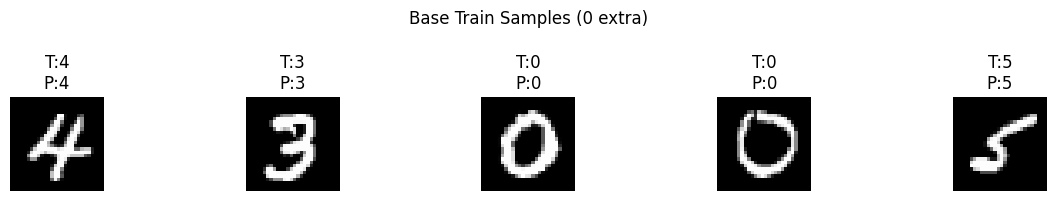

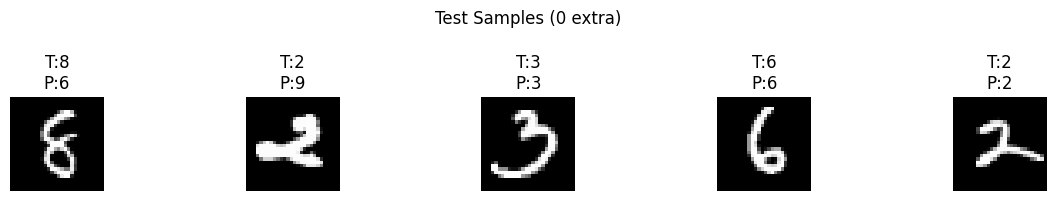

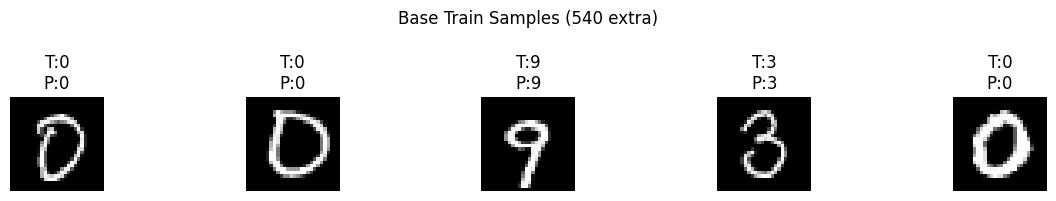

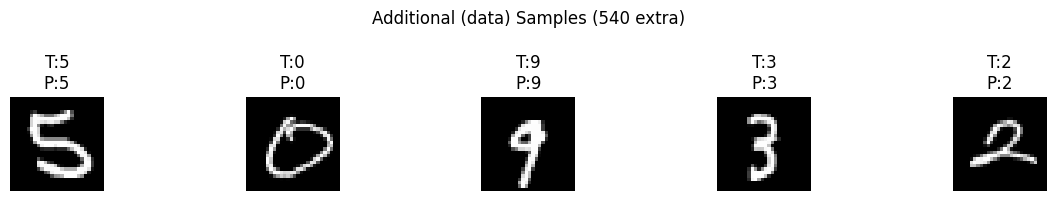

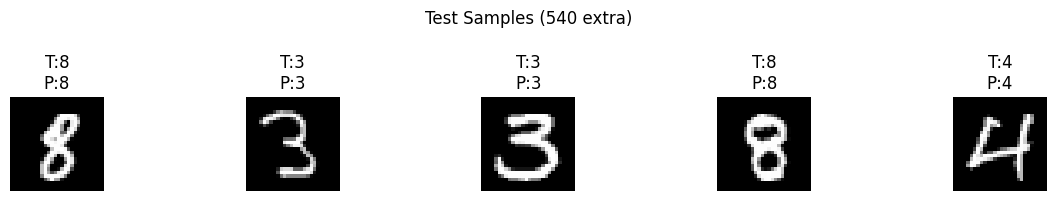

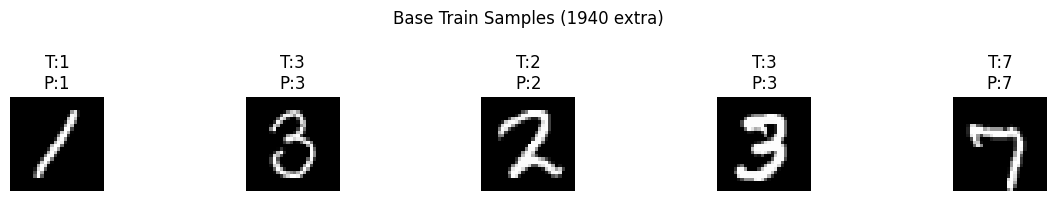

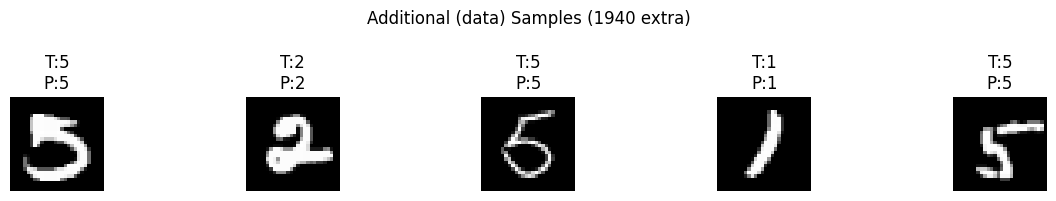

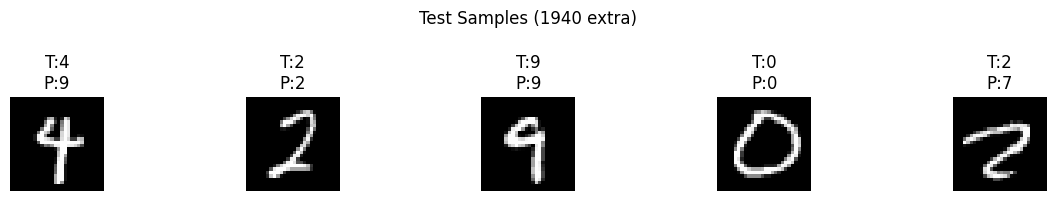

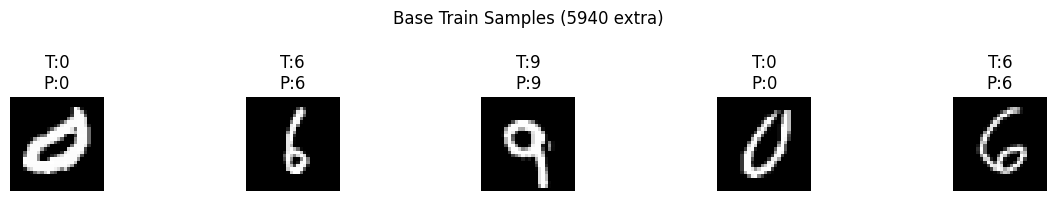

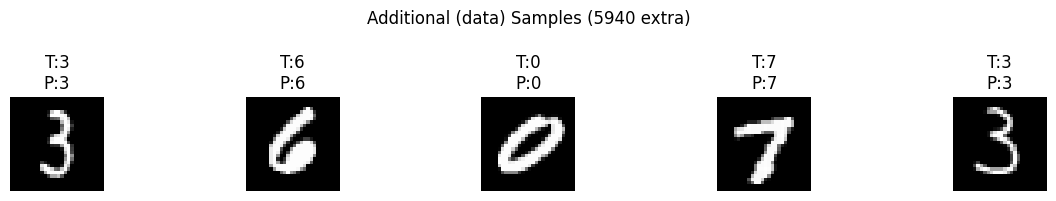

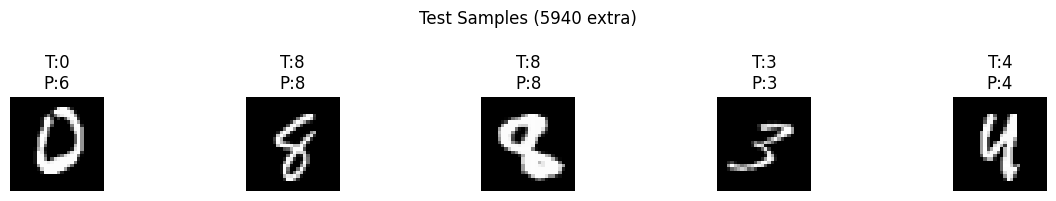

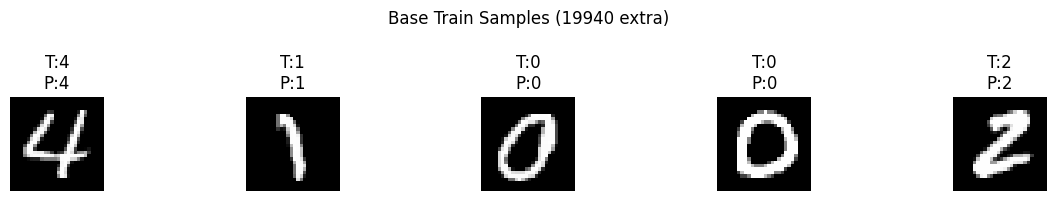

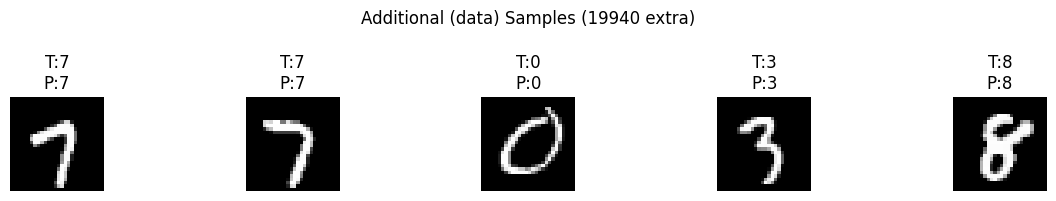

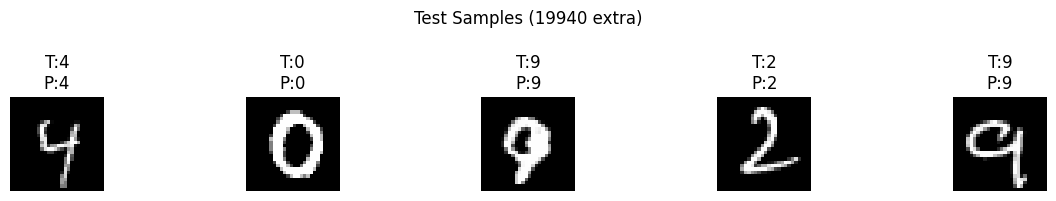

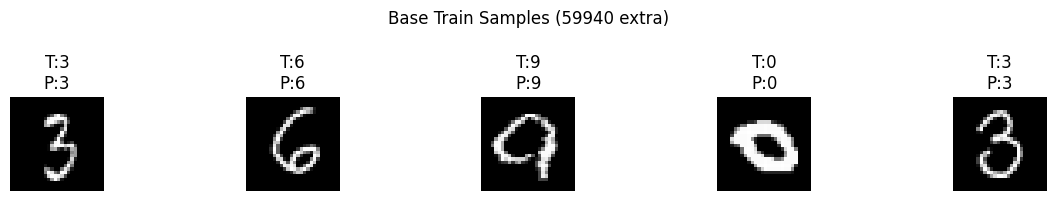

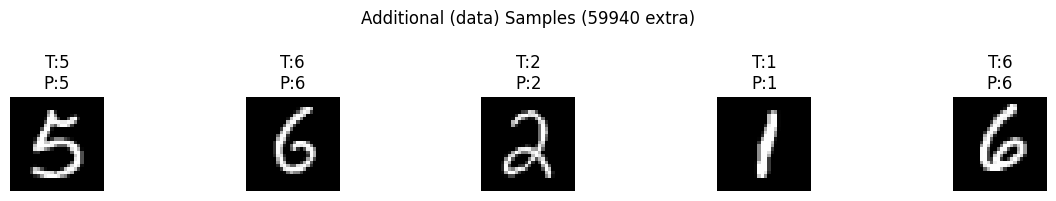

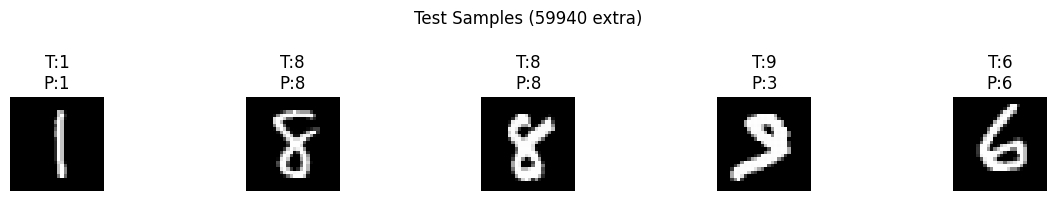

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
